# 대회
>https://bd.kma.go.kr/contest/info_01.do

>240371

>0704

* 개선을 위한 방법
1. 마지막엔 test을 나누지말고 그냥 전부 train 시켜버린다
2. 쓸데 없는 열을 버려본다?
3. 앙상블 모델을 써볼까?

* 코드 순서
1. df에서 지역별로 5개 나눠서 각자 자기꺼(e, 남해)만 출력 후 아래의 전처리 동일하게 진행
2. 문자형식은 수치화하기
3. 선형보간법으로 독립변수 결측값 대체
4. re(0, 1) 결측값 대체 방법 선정 -> 직전값
5. 선형보간법으로 독립변수 이상치 대체
6. 정규화 방법 선정 -> 월별 계절성을 반영한 min-max scaler
7. target(vis1, class) 결측값 대체 방법 선정 -> random forest (seed: 123)
8. 파생변수 생성
9. lstm 적용 (sequence = 6) # 1시간 단위로 설정
10. 가중치 조절

In [ ]:
# 샘플링
# 시퀀스 30에서 늘리기
# class 결측치 채워보기

In [31]:
import pandas as pd
import numpy as np
import joblib

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# # 시간
# df['year'].value_counts() # 년도
# df['month'].value_counts() # 월
# df['day'].value_counts() # 일
# df['time'].value_counts() # 시간(0~23)
# df['minute'].value_counts() # 분(10분 단위)
# df['stn_id'].value_counts() # 지점 번호

# -99 있음
# df['ws10_deg'].value_counts() # 10분 평균 풍향, 단위 : deg
# df['ws10_ms'].value_counts() # 10분 평균 풍속, 단위 : m/s
# df['ta'].value_counts() # 1분 평균 기온 10분 주기, 단위 : C
# df['re'].value_counts() # 강수 유무(0:무강수, 1:강수)
# df['hm'].value_counts() # 1분 평균 상대 습도 10분 주기, 단위 : %
# df['sun10'].value_counts() # 1분 일사량 10분 단위 합계, 단위 : MJ
# df['ts'].value_counts() # 1분 평균 지면온도 10분 주기, 단위 : C
# df['vis1'].value_counts() # 1분 평균 시정 10분 주기, 단위 : C(test데이터 셋엔 없음)
# df['class'].value_counts() # 시정 구간

# 파생변수
# df['season'].value_counts() # 계절(봄부터 0)
# df['dew_point'].value_counts() # 이슬점
# df['ws10_deg_16'].value_counts() # 16방위 풍향
# df['diurnal_range'].value_counts() # 일교차
# df['ts_dew_diff'].value_counts() # 기온-이슬점
# df['5_hm'].value_counts()# 50분 이동평균(습도)

# 7. 파생변수

In [21]:
df = df_xgr.copy()

**파생변수** 

In [24]:
# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)

In [25]:
# 이슬점(dew_point)

import math

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    # 상대 습도가 0이면 매우 낮은 값을 설정하여 log(0)가 발생하지 않도록 한다.
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [86]:
# 될지 모르겠다.
# 새벽 4-8시의 평균 이슬점
'''
# minute이 4, 5, 6, 7, 8인 데이터를 필터링하여 평균 dew_point 계산
avg_dew_point = df[df['minute'].isin([4, 5, 6, 7, 8])].groupby(['year', 'month', 'day', 'stn_id'])['dew_point'].mean()
avg_dew_point = avg_dew_point.reset_index()

# 기존 데이터프레임에 평균 dew_point 열을 병합
df = pd.merge(df, avg_dew_point, on=['year', 'month', 'day', 'stn_id'], how='left', suffixes=('', '_avg'))
'''

"\n# minute이 4, 5, 6, 7, 8인 데이터를 필터링하여 평균 dew_point 계산\navg_dew_point = df[df['minute'].isin([4, 5, 6, 7, 8])].groupby(['year', 'month', 'day', 'stn_id'])['dew_point'].mean()\navg_dew_point = avg_dew_point.reset_index()\n\n# 기존 데이터프레임에 평균 dew_point 열을 병합\ndf = pd.merge(df, avg_dew_point, on=['year', 'month', 'day', 'stn_id'], how='left', suffixes=('', '_avg'))\n"

In [26]:
# 풍향
# 풍향을 16방위로 변환하는 함수
def convert_wind_direction(wind_dir):
    # 22.5도 간격으로 16방위로 매핑
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction

# 풍향을 16방위로 변환하여 새로운 열에 추가
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# # 원-핫 인코딩을 위해 더미 변수 생성
# df = pd.get_dummies(df, columns=['wind_direction_16'], prefix='wind_dir')

In [27]:
# 일교차(diurnal_range)
# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

In [28]:
# 기온-이슬점(안개형성조건, 기온이 이슬점 이하일 때 잘 발생)
df['ts_dew_diff'] = df['ts'] - df['dew_point']

In [29]:
# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group

# 각 stn_id별로 그룹화하여 함수 적용
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [30]:
df_pluscol = df.copy()

## 8-1. LSTM-1(양방향)

In [32]:
df = df_pluscol.copy()

In [33]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're','ws10_deg_16',]
target = 'vis1'

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features + [target]]

In [34]:
# 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.
original_indices = data.index
# 라벨 인코딩을 위한 LabelEncoder 객체 생성
label_encoders = {feature: LabelEncoder() for feature in categorical_features}
# 카테고리형 변수에 대해 라벨 인코딩을 적용
encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].fit_transform(x))
# 인코딩된 카테고리형 변수와 원본 데이터프레임을 합침
processed_data = pd.concat([data[numeric_features], encoded_categorical_data, data[target]], axis=1)

In [35]:
# 계절을 반영한 Min-Max 스케일링
scaler = MinMaxScaler()
scaled_numeric_data = data.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.fit_transform(scaled_numeric_data.loc[mask, numeric_features])

# 숫자형 변수와 라벨 인코딩된 카테고리형 변수를 합침
processed_data = pd.concat([scaled_numeric_data[numeric_features], encoded_categorical_data, data[target]], axis=1)

In [36]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(columns=[target])
        label = data.iloc[i + sequence_length][target]
        sequences.append(seq.values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(processed_data, sequence_length)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)


In [ ]:
# 양방향 LSTM 모델 구성
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, X_train.shape[-1])))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, # 로그출력
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
31565/31565 [==============================] - 734s 23ms/step - loss: 242362864.0000 - val_loss: 198228736.0000
Epoch 2/100
31565/31565 [==============================] - 624s 20ms/step - loss: 161225792.0000 - val_loss: 127130288.0000
Epoch 3/100
31565/31565 [==============================] - 597s 19ms/step - loss: 100222392.0000 - val_loss: 76076120.0000
Epoch 4/100
31565/31565 [==============================] - 538s 17ms/step - loss: 59236236.0000 - val_loss: 44927848.0000
Epoch 5/100
31565/31565 [==============================] - 529s 17ms/step - loss: 38011996.0000 - val_loss: 33134252.0000
Epoch 6/100
31565/31565 [==============================] - 22858s 724ms/step - loss: 33263500.0000 - val_loss: 32545590.0000
Epoch 7/100
31565/31565 [==============================] - 528s 17ms/step - loss: 33178680.0000 - val_loss: 32543940.0000
Epoch 8/100
31565/31565 [==============================] - 541s 17ms/step - loss: 33179792.0000 - val_loss: 32544360.0000
Epoch 9/100
3156

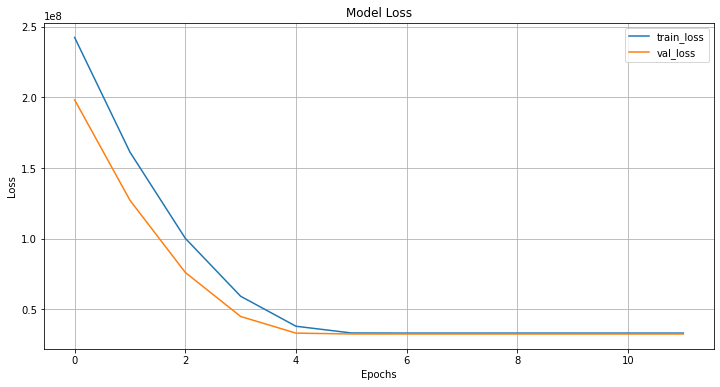

In [ ]:
# history 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 모델 평가
y_pred = model.predict(X_test)

19728/19728 [==============================] - 78s 4ms/step


In [ ]:
# 예측된 vis1을 바탕으로 class를 계산
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])
y_test_class = np.array([classify_vis1(vis) for vis in y_test])

In [ ]:
# CSI 계산 예시 (필요에 따라 추가적으로 수행)
def calculate_csi(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    csi_values = []
    for i in range(1, 5):  # class 1 to 4
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        csi_values.append(csi)
    return np.mean(csi_values)

csi = calculate_csi(y_test_class, y_pred_class)
print(f'CSI: {csi}')

CSI: 0.2474868959006227


In [ ]:
from keras.models import load_model

#모델 저장
model.save('model_1.h5')

# 노트북
model.save('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

# 데스크탑
# model.save('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 전처리기 저장
joblib.dump(scaler, 'scaler_1.pkl')
joblib.dump(label_encoders, 'label_encoders_1.pkl')

# 노트북
joblib.dump(scaler, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler_1.pkl')
joblib.dump(label_encoders, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders_1.pkl')

# # 데스크탑
# joblib.dump(scaler, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler.pkl')
# joblib.dump(label_encoders, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders.pkl')

['C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders_1.pkl']

### fog_test.csv을 예측 

In [ ]:
# 데스크탑
# df_test = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

# 노트북
df_test = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

In [ ]:
df_original = df_test.copy()
df = df_test.copy()

**기본 전처리**

In [ ]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

# year열 I, J, K 순으로 0, 1, 2로 맵핑 (현재 L만 있어서 0으로 맵핑)
df['year'] = df['year'].map({'L': 0})

# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
stn_id_mapping = {v: k for k, v in enumerate(['AI', 'BE', 'CC', 'DD'])}
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

In [ ]:
# 마지막 행이 결측열이길래 제거
df.loc[:, df.columns != 'class'] = df.loc[:, df.columns != 'class'].fillna(method='ffill')

**결측치 제거**

In [ ]:
# nan_cols : na로변환할 열 리스트
nan_cols = ['stn_id', 'ws10_deg', 'ws10_ms', 'ta','re', 'hm', 'sun10', 'ts']
# -99.9 값을 NaN으로 변환
df[nan_cols] = df[nan_cols].replace(-99.9, np.nan)
# -99값을 NaN으로 변환
df['class'] = df['class'].replace(-99, np.nan)

# numeric_cols : 선형보간법으로 처리할 리스트
numeric_cols = ['stn_id', 'ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')
print(df.isnull().sum())

year             0
month            0
day              0
time             0
minute           0
stn_id           0
ws10_deg         0
ws10_ms          0
ta               0
re               0
hm               0
sun10            0
ts               0
class       168968
region           0
dtype: int64


**이상치 탐지&제거**

In [ ]:
features = df.columns.difference(['year', 'month', 'day', 'time', 're', 'stn_id', 'minute', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    outliers_indices = {}
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = np.where((data > ucl) | (data < lcl))[0]
        outliers_indices[feature] = outliers
    return outliers_indices
# 이상치 탐지
outliers_indices = detect_outliers(df, features)

# 이상치 대체 함수 정의
def replace_outliers(df, outliers_indices):
    for feature, indices in outliers_indices.items():
        df.loc[indices, feature] = np.nan
        df[feature] = df[feature].interpolate(method='polynomial', order=2) # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df
# 이상치 대체 수행
replace_outliers(df, outliers_indices)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,region
1,0,1,1,0,0,0,329.5,0.6,-2.5,0.0,87.5,0.00,-1.6,NaN,0
2,0,1,1,0,10,0,321.8,1.2,-2.5,0.0,88.2,0.00,-1.6,NaN,0
3,0,1,1,0,20,0,0.4,0.4,-2.5,0.0,88.6,0.00,-1.7,NaN,0
4,0,1,1,0,30,0,323.6,0.7,-2.6,0.0,88.7,0.00,-1.6,NaN,0
5,0,1,1,0,40,0,208.4,0.2,-2.6,0.0,89.0,0.00,-1.6,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168964,0,3,20,8,30,3,166.2,0.6,2.9,0.0,93.7,0.15,6.8,NaN,3
168965,0,3,20,8,40,3,51.7,0.8,3.6,0.0,92.4,0.18,7.1,NaN,3
168966,0,3,20,8,50,3,301.8,0.9,3.5,0.0,91.2,0.19,7.4,NaN,3
168967,0,3,20,9,0,3,290.7,0.3,3.8,0.0,91.5,0.22,8.2,NaN,3


**파생 변수**

In [ ]:
# 계절 매핑
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울
df['season'] = df['month'].apply(map_season)

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + np.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

# 풍향을 16방위로 변환
def convert_wind_direction(wind_dir):
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

# 기온-이슬점
df['ts_dew_diff'] = df['ts'] - df['dew_point']

# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

**LSTM 적용부분**

In [ ]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're','ws10_deg_16',]

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features]

# 라벨 인코딩 및 스케일러 로드
label_encoders = joblib.load('label_encoders_1.pkl')
scaler = joblib.load('scaler_1.pkl')

# 카테고리형 변수에 대해 라벨 인코딩을 적용
encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].transform(x))
processed_data = pd.concat([data[numeric_features], encoded_categorical_data], axis=1)


# 계절을 반영한 Min-Max 스케일링
scaled_numeric_data = processed_data.copy()
for season_value in range(4):
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.transform(scaled_numeric_data.loc[mask, numeric_features])

processed_data = pd.concat([scaled_numeric_data[numeric_features], encoded_categorical_data], axis=1)


In [ ]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        sequences.append(seq.values)
    return np.array(sequences)

sequences_test = create_sequences(processed_data, sequence_length)

In [ ]:
# 모델 적용
from keras.models import load_model

model = load_model('model_1.h5')
y_pred = model.predict(sequences_test)

def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])

5281/5281 [==============================] - 26s 5ms/step


In [ ]:
y_pred

array([[16015.454],
       [16015.454],
       [16015.454],
       ...,
       [16015.454],
       [16015.454],
       [16015.454]], dtype=float32)

In [ ]:
# 예측 결과를 DataFrame에 추가
df_original['fog_test.class'].iloc[sequence_length:] = y_pred_class
df_original.loc[:, df_original.columns != 'class'] = df_original.loc[:, df_original.columns != 'class'].fillna(method='bfill')

# 예측 결과 출력 또는 저장
# print(df_original[['year', 'month', 'day', 'time', 'fog_test.class']])

# CSV로 저장
df_original.to_csv('predicted_results.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_19128\24892146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_original['fog_test.class'].iloc[sequence_length:] = y_pred_class


In [ ]:
df_original['fog_test.class'].value_counts()

4.0    168968
Name: fog_test.class, dtype: int64

In [ ]:
# 노트북
df_original.to_csv('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)

# 데스크탑
# df_original.to_csv('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)